In [1]:
import collections
import concurrent.futures as cf
import datetime
import gc
import itertools
import math
from pathlib import Path

import IPython.display as ipd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.csv
import pyarrow.compute
import pyarrow.parquet as pq
from tqdm.auto import tqdm

from geo_transformers import num_utils

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
IN_PATH = "locations/"
OUT_PATH = "locations_12h/"

In [4]:
TOLERANCE = np.timedelta64(3, "h")  # max time diff to midnight / noon
MIN_DIFF = np.timedelta64(9, "h")   # min time diff between consecutive samples
MAX_DIFF = np.timedelta64(15, "h")  # max time diff between consecutive samples
MIN_LEN = 120

In [5]:
schema_out = pa.schema([
    ("timestamp", pa.timestamp("us")),
    ("location_lat", pa.float64()),
    ("location_long", pa.float64()),
    ("study_id", pa.string()),
    ("individual_id", pa.string()),
    ("deployment_id", pa.int64()),
    ("seq_id", pa.string()),
#     ("section", pa.string())
])

In [6]:
table = pq.read_table(IN_PATH).drop(["tag_id"])
index_values, index_offsets, index_ends = num_utils.find_repeated(table["deployment_id"].to_numpy())
index_lengths = index_ends - index_offsets
table_index = dict(zip(index_values, zip(index_offsets, index_lengths)))

deployment_ids = sorted(table_index.keys())
np.random.default_rng(0).shuffle(deployment_ids)

In [7]:
def process_traj(deployment_id):
    batches_out = []

    traj = table.slice(*table_index[deployment_id])
    traj_df = traj.to_pandas(timestamp_as_object=True)
    traj_df = traj_df.sort_values(by="timestamp").reset_index(drop=True)

    orig_len = len(traj_df)
    orig_len_sec = (traj_df["timestamp"].max() - traj_df["timestamp"].min()).total_seconds()
    total_trajs = 0
    total_events = 0
    total_covered = 0

    times = traj_df["timestamp"].to_numpy(copy=True).astype("datetime64[us]")
    # compute local mean time based on longitude
    shift_us = traj_df["location_long"] / 180 * 12 * 3600 * 1e6
    times += shift_us.astype("timedelta64[us]")

    # round to nearest midnight/noon
    halfday = np.timedelta64(12, "h").astype("timedelta64[us]")
    times_midnight = (times + halfday).astype("datetime64[D]").astype("datetime64[us]")
    times_noon = times.astype("datetime64[D]").astype("datetime64[us]") + halfday
    times_rounded = np.where(np.abs(times - times_midnight) < np.abs(times - times_noon), times_midnight, times_noon)

    def pick_closest(df):
        df = df.query("abs(timestamp_lmt - time_rounded) <= @TOLERANCE")
        if not len(df):
            return df.iloc[[]]
        return df.iloc[[df.eval("abs(timestamp_lmt - time_rounded)").argmin()]]

    # select based on local mean time, do not touch original timestamps
    traj_df = traj_df.assign(timestamp_lmt=times, time_rounded=times_rounded).groupby("time_rounded").apply(pick_closest)
    subtraj = []
    for _, row in traj_df.eval("timestamp_diff = timestamp.astype('datetime64[us]').diff()").iterrows():
        if row["timestamp_diff"] < MIN_DIFF or row["timestamp_diff"] > MAX_DIFF:
            if len(subtraj) >= MIN_LEN:
                subtraj_df = pd.DataFrame.from_records(subtraj)
                subtraj_df["seq_id"] = f"{deployment_id}_{len(batches_out)}"

                batches_out.append(pa.RecordBatch.from_pandas(
                    subtraj_df, schema=schema_out, preserve_index=False))
                
                total_trajs += 1
                total_events += len(subtraj_df)
                total_covered += (subtraj_df["timestamp"].max() - subtraj_df["timestamp"].min()).total_seconds()

            subtraj = [row]
        else:
            subtraj.append(row)
    
    return batches_out, total_trajs, orig_len, orig_len_sec, total_events, total_covered

total_trajs, total_orig_len, total_orig_len_sec, total_new_len, total_covered = 0, 0, 0, 0, 0
all_batches = []

#[process_traj(di) for di in tqdm(deployment_ids)]

with cf.ProcessPoolExecutor(32) as pool:
    with tqdm(total=len(deployment_ids)) as pbar:
        futures = cf.as_completed([pool.submit(process_traj, di) for di in deployment_ids])
        for future in futures:
            batches_out, num_trajs, orig_len, orig_len_sec, new_len, covered_sec = future.result()
            all_batches.extend(batches_out)
            total_trajs += num_trajs
            total_orig_len += orig_len
            total_orig_len_sec += orig_len_sec
            total_new_len += new_len
            total_covered += covered_sec

            pbar.set_postfix(trajs=total_trajs,
                             events=total_new_len,
                             avg_len=total_new_len/total_trajs if total_trajs > 0 else 0,
                             tcov=total_covered/total_orig_len_sec if total_orig_len_sec > 0 else np.nan)
            pbar.update(1)

  0%|          | 0/13702 [00:00<?, ?it/s]

In [8]:
pbar.postfix

'avg_len=330, events=1006936, tcov=0.228, trajs=3052'

In [101]:
table_out = pa.Table.from_batches(all_batches, schema=schema_out)
table_out = table_out.sort_by([("study_id", "ascending"),
                               ("seq_id", "ascending"),
                               ("timestamp", "ascending")])

In [4]:
individuals = pq.read_table("individuals.parquet").to_pandas().set_index("id")

In [ ]:
taxon_counts = table_out.select(["individual_id", "seq_id"]).to_pandas().join(individuals, on="individual_id").groupby(["taxon"]).agg({"individual_id": "nunique", "seq_id": ["nunique", "count"]}).sort_values(by=("individual_id", "nunique"), ascending=False)

with pd.option_context('display.max_rows', 100):
    ipd.display(taxon_counts)

In [104]:
taxon_counts.sum()

individual_id  nunique       1506
seq_id         nunique       3052
               count      1006936
dtype: int64

In [105]:
# Select individuals available for test/validation set
avail_taxons = list(taxon_counts[taxon_counts["individual_id", "nunique"] >= 10].index)
avail_taxons.remove("")
avail_individuals = list(individuals.query("taxon in @avail_taxons").index)

# Do train/val/test split
len_val, len_test = len(avail_individuals) // 25, len(avail_individuals) // 20
np.random.default_rng(0).shuffle(avail_individuals)
ids_val = pa.array(avail_individuals[:len_val])
ids_test = pa.array(avail_individuals[len_val:len_val + len_test])
section_names = np.select([
    pa.compute.is_in(table_out["individual_id"], ids_val).to_numpy(),
    pa.compute.is_in(table_out["individual_id"], ids_test).to_numpy()
], ["val", "test"], "train")
table_out_split = table_out.append_column("section", pa.array(section_names))

# Check that the training set has all the taxons
assert set(table_out_split.to_pandas().query("section == 'train'").join(individuals, on="individual_id")["taxon"]) == set(table_out.select(["individual_id"]).to_pandas().join(individuals["taxon"], on="individual_id")["taxon"])

In [106]:
taxon_counts_split = table_out_split.select(["individual_id", "seq_id", "section"]).to_pandas().join(individuals, on="individual_id").groupby(["taxon", "section"]).agg({"individual_id": "nunique", "taxon": ["nunique"], "seq_id": ["nunique", "count"]}).sort_values(by=("individual_id", "nunique"), ascending=False)
ipd.display(taxon_counts_split.groupby("section").sum())

individual_id   taxon  seq_id        
              nunique nunique nunique   count
section                                      
test               70      23     133   40334
train            1383      63    2786  915618
val                53      17     133   50984

In [107]:
pq.write_to_dataset(table_out_split, OUT_PATH, partition_cols=["section", "study_id"])

<AxesSubplot:ylabel='Frequency'>

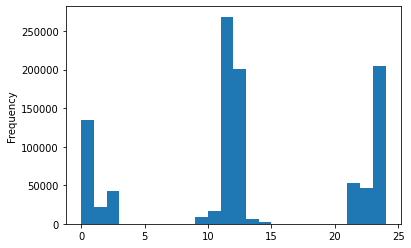

In [108]:
df = pq.read_table(OUT_PATH, columns=["timestamp", "location_long"]).to_pandas()
((df["timestamp"].dt.hour + df["timestamp"].dt.minute / 60 + df["location_long"] / 15 + 24) % 24).plot.hist(bins=np.linspace(0., 24., 25))

/tmp/ipykernel_3782196/4115562341.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, bins = np.histogram((df["timestamp"].dt.hour + df["timestamp"].dt.minute / 60 + df["location_long"] / 15 + 24) % 24, bins=np.linspace(0., 24., 25), normed=True)


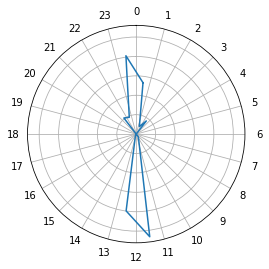

In [114]:
df = pq.read_table(OUT_PATH, columns=["timestamp", "location_long"]).to_pandas()
hist, bins = np.histogram((df["timestamp"].dt.hour + df["timestamp"].dt.minute / 60 + df["location_long"] / 15 + 24) % 24, bins=np.linspace(0., 24., 25), normed=True)
plt.polar((bins + 0.5) / 24 * 2 * np.pi, [*hist, hist[0]])
plt.gca().set_theta_zero_location('N')
plt.gca().set_theta_direction(-1)
plt.xticks(np.arange(24) / 24 * 2 * np.pi, np.arange(24))
plt.gca().set_yticklabels([])
plt.show()

<AxesSubplot:ylabel='Frequency'>

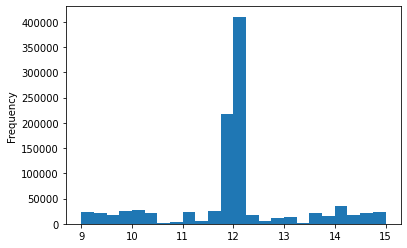

In [117]:
(pq.read_table(OUT_PATH, columns=["timestamp", "seq_id"]).to_pandas()
 .groupby("seq_id")["timestamp"].apply(pd.Series.diff)
 .apply(lambda dt: dt.total_seconds() / 3600)
 .plot.hist(bins=24))